# MNIST Classification Showdown

# 0. Imports and Datasets

In [2]:
# %pip install ml_collections
# %pip install flax
# %pip install bayesian-optimization
# %pip install -qq git+https://github.com/probml/rebayes.git
# %pip install jaxtyping
# %pip install jax-tqdm
# %pip install dynamax

In [1]:
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque
from tqdm import trange

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from bayes_opt import BayesianOptimization

jax.numpy.set_printoptions(suppress = True, precision=4)
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF
import demos.showdown.hparam_tune_clf as hp

In [2]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('fashion_mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    train_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:80%]', batch_size=-1))
    val_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[80%:]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    for ds in [train_ds, train_tvsplit_ds, val_tvsplit_ds, test_ds]:
        ds['image'] = jnp.float32(ds['image']) / 255.
    return train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds

In [3]:
train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds = get_datasets()

In [4]:
X_train, y_train = jnp.array(train_ds['image']), jnp.array(train_ds['label'])
X_test, y_test = jnp.array(test_ds['image']), jnp.array(test_ds['label'])

In [5]:
# Reshape data
X_train = X_train.reshape(-1, 1, 28, 28, 1)
y_train_ohe = jax.nn.one_hot(y_train, 10)

# 1. Models

In [6]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [7]:
cnn = CNN()
key = jr.PRNGKey(0)
params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
flat_params, unflatten_fn = ravel_pytree(params)
print(f'Params size = {flat_params.shape}')
state_dim = flat_params.shape[0]

Params size = (421642,)


In [8]:
apply_fn = lambda w, x: cnn.apply({'params': unflatten_fn(w)}, x).ravel()
emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
def emission_cov_function(w, x):
    ps = emission_mean_function(w, x)
    return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity

In [9]:
test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}

In [10]:
def evaluate_neg_log_likelihood(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label)
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

In [11]:
def evaluate_miscl(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate accuracy for given parameters and test set
    """
    @jit
    def evaluate_miscl(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        acc_test = (logits.argmax(axis=-1) == label).mean()
        return 1.0 - acc_test
    miscls = vmap(evaluate_miscl, (0, 0))(test_set['label'], test_set['image'])
    return miscls.mean()

In [12]:
def nll_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    nll = evaluate_neg_log_likelihood(bel.mean, unflatten_fn, apply_fn, test_set)
    return nll

In [13]:
def miscl_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    miscl = evaluate_miscl(bel.mean, unflatten_fn, apply_fn, test_set)
    return miscl

In [14]:
def get_config(
    optimizer='sgd',
    learning_rate=0.01, 
    momentum=2e-1,
    init_var=3e-2,
    num_iter=1,
    batch_size=1, 
    num_epochs=1,
    sample_freq=500,
    posterior_predictive_method='mc',
    seed=0
    ):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.optimizer = optimizer
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.init_var = init_var
    config.num_iter = num_iter
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.sample_freq = sample_freq
    config.posterior_predictive_method = posterior_predictive_method
    config.seed = seed
    return config

# 2. Orth-SVD LoFi

## 2.1 Hyperparam Tuning

In [15]:
def lofi_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, memory_size, method='orth_svd_lofi'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    lofi_params = LoFiParams(
        memory_size=int(memory_size),
    )
    estimator = RebayesLoFi(model_params, lofi_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=nll_callback, progress_bar=False, **test_kwargs)
    result = -output.mean()
    if jnp.isnan(result):
        result = -1e6

    return result

In [16]:
os_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='orth_svd_lofi')
os_lofi_optimizer = BayesianOptimization(
    f=os_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-7, -0.1),
        'log_dynamics_cov': (-7, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [17]:
os_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -1.962    | -0.103    | -3.131    | -4.821    |
| 2         | -2.889    | -4.24     | -2.576    | -3.282    |
| 3         | -1.807    | -2.811    | -3.268    | -3.486    |
| 4         | -45.03    | -1.048    | -1.723    | -0.4167   |
| 5         | -973.4    | -5.858    | -0.9649   | -1.667    |
| 6         | -1.386    | -4.594    | -4.768    | -2.291    |
| 7         | -1.674    | -1.987    | -4.981    | -6.563    |
| 8         | -658.2    | -4.972    | -0.5302   | -0.247    |
| 9         | -1.057e+0 | -3.989    | -1.421    | -3.35     |
| 10        | -1.187    | -3.907    | -4.896    | -0.7852   |
| 11        | -74.58    | -1.609    | -2.645    | -1.097    |
| 12        | -1.226e+0 | -1.253    | -2.386    | -5.744    |
| 13        | -1.452    | -4.229    | -4.111    | -5.724    |
| 14        | -58.23    | -4.343    | -1.776    | -5.674    |
| 15    

In [18]:
# 'log_alpha': -3.71635973991954, 'log_dynamics_cov': -6.435196338423327, 'log_init_cov': -1.016050899184398
print(os_lofi_optimizer.max)

{'target': -1.1644529104232788, 'params': {'log_alpha': -3.71635973991954, 'log_dynamics_cov': -6.435196338423327, 'log_init_cov': -1.016050899184398}}


## 2.2 Test-Set NLL Evaluation

In [32]:
def evaluate_model(estimator, X, y, test_kwargs, key=0, n_steps=1_000, n_iter=10, callback=nll_callback):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = estimator.scan(X_curr, y_curr, callback=callback, **test_kwargs, progress_bar=True)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [33]:
init_cov = jnp.power(10, -1.016050899184398)
dynamics_cov = jnp.power(10, -6.435196338423327)
alpha = jnp.power(10, -3.71635973991954)
method = 'orth_svd_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
os_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [34]:
os_lofi_mean, os_lofi_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
os_lofi_miscl_mean, os_lofi_miscl_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

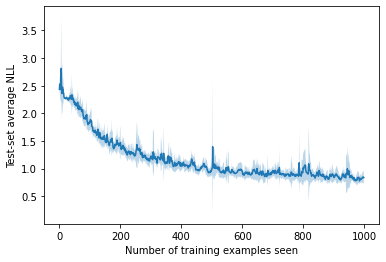

In [36]:
fig, ax = plt.subplots()
ax.plot(os_lofi_mean)
ax.fill_between(
    jnp.arange(os_lofi_mean.shape[0]),
    os_lofi_mean - os_lofi_std,
    os_lofi_mean + os_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

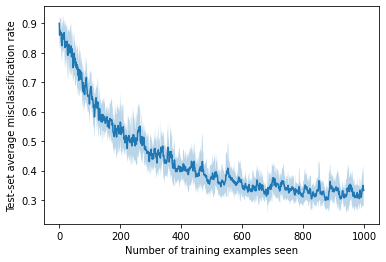

In [37]:
fig, ax = plt.subplots()
ax.plot(os_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(os_lofi_miscl_mean.shape[0]),
    os_lofi_miscl_mean - os_lofi_miscl_std,
    os_lofi_miscl_mean + os_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 3. Full-SVD LoFi

## 3.1 Hyperparam Tuning

In [19]:
fs_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='full_svd_lofi')
fs_lofi_optimizer = BayesianOptimization(
    f=fs_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-7, -0.1),
        'log_dynamics_cov': (-7, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [20]:
fs_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -67.72    | -4.242    | -2.73     | -4.794    |
| 2         | -1.917    | -5.399    | -5.449    | -6.014    |
| 3         | -1.436    | -1.059    | -6.716    | -2.5      |
| 4         | -1.4      | -5.202    | -4.734    | -5.135    |
| 5         | -97.26    | -3.206    | -0.4308   | -6.385    |
| 6         | -0.9636   | -4.573    | -4.71     | -1.188    |
| 7         | -1.327    | -6.298    | -3.918    | -0.7272   |
| 8         | -2.278    | -5.701    | -6.84     | -4.726    |
| 9         | -102.2    | -1.995    | -2.532    | -6.615    |
| 10        | -1.297    | -5.292    | -4.474    | -4.58     |
| 11        | -2.283    | -6.433    | -6.816    | -6.94     |
| 12        | -1.929    | -1.17     | -5.477    | -4.703    |
| 13        | -50.29    | -0.536    | -0.2927   | -5.296    |
| 14        | -1.343    | -0.962    | -4.198    | -4.655    |
| 15    

In [21]:
# 'log_alpha': -4.5732368793501, 'log_dynamics_cov': -4.709671286426655, 'log_init_cov': -1.1881793383532422
print(fs_lofi_optimizer.max)

{'target': -0.9636155366897583, 'params': {'log_alpha': -4.5732368793501, 'log_dynamics_cov': -4.709671286426655, 'log_init_cov': -1.1881793383532422}}


## 3.2 Test-Set NLL Evaluation

In [38]:
init_cov = jnp.power(10, -1.1881793383532422)
dynamics_cov = jnp.power(10, -4.709671286426655)
alpha = jnp.power(10, -4.5732368793501)
method = 'full_svd_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
fs_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [39]:
fs_lofi_mean, fs_lofi_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
fs_lofi_miscl_mean, fs_lofi_miscl_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

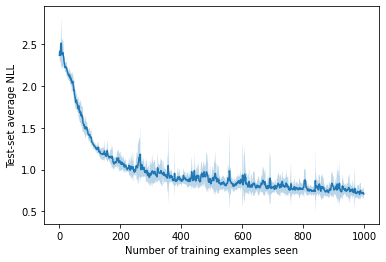

In [41]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_mean)
ax.fill_between(
    jnp.arange(fs_lofi_mean.shape[0]),
    fs_lofi_mean - fs_lofi_std,
    fs_lofi_mean + fs_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

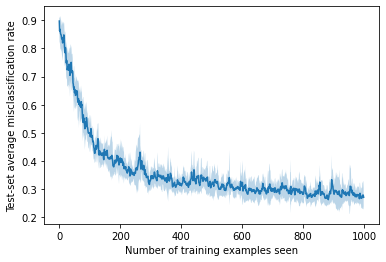

In [42]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(fs_lofi_miscl_mean.shape[0]),
    fs_lofi_miscl_mean - fs_lofi_miscl_std,
    fs_lofi_miscl_mean + fs_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 4. Generalized LoFi

## 4.1 Hyperparam Tuning

In [22]:
g_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='generalized_lofi')
g_lofi_optimizer = BayesianOptimization(
    f=g_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-7, -0.1),
        'log_dynamics_cov': (-7, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [23]:
g_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.206    | -2.684    | -5.996    | -4.944    |
| 2         | -273.5    | -5.578    | -1.037    | -3.48     |
| 3         | -2.528    | -1.798    | -1.961    | -5.966    |
| 4         | -1.437    | -0.6527   | -3.354    | -5.789    |
| 5         | -92.21    | -1.229    | -0.3492   | -3.88     |
| 6         | -1.308    | -0.739    | -3.651    | -1.687    |
| 7         | -134.3    | -1.698    | -1.585    | -5.885    |
| 8         | -2.21     | -5.14     | -6.973    | -3.527    |
| 9         | -2.533    | -1.157    | -2.042    | -5.654    |
| 10        | -1.348    | -0.7823   | -3.514    | -3.391    |
| 11        | -1.163    | -2.481    | -3.868    | -2.959    |
| 12        | -1.506e+0 | -4.96     | -0.8041   | -3.479    |
| 13        | -1.454e+0 | -5.086    | -1.463    | -0.487    |
| 14        | -1.997    | -0.3425   | -5.632    | -3.748    |
| 15    

In [24]:
# 'log_alpha': -6.196874151388207, 'log_dynamics_cov': -3.9437993352932557, 'log_init_cov': -1.5076846611252455
print(g_lofi_optimizer.max)

{'target': -1.0592334270477295, 'params': {'log_alpha': -6.196874151388207, 'log_dynamics_cov': -3.9437993352932557, 'log_init_cov': -1.5076846611252455}}


## 4.2 Test-Set NLL Evaluation

In [43]:
init_cov = jnp.power(10, -1.5076846611252455)
dynamics_cov = jnp.power(10, -3.9437993352932557)
alpha = jnp.power(10, -6.196874151388207)
method = 'generalized_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
g_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [44]:
g_lofi_mean, g_lofi_std = evaluate_model(g_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [45]:
g_lofi_miscl_mean, g_lofi_miscl_std = evaluate_model(g_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

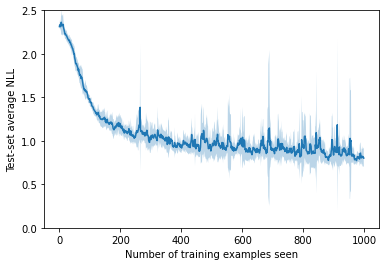

In [46]:
fig, ax = plt.subplots()
ax.plot(g_lofi_mean)
ax.fill_between(
    jnp.arange(g_lofi_mean.shape[0]),
    g_lofi_mean - g_lofi_std,
    g_lofi_mean + g_lofi_std,
    alpha=0.3
)
ax.set_ylim(0.0, 2.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

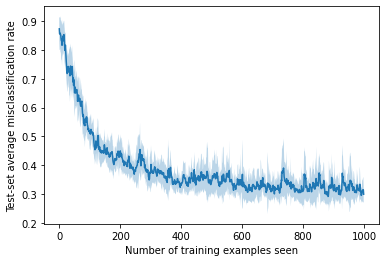

In [47]:
fig, ax = plt.subplots()
ax.plot(g_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(g_lofi_miscl_mean.shape[0]),
    g_lofi_miscl_mean - g_lofi_miscl_std,
    g_lofi_miscl_mean + g_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 5. FD-EKF

## 5.1 Hyperparam Tuning

In [25]:
def ekf_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, method='fdekf'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    estimator = RebayesEKF(model_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=nll_callback, progress_bar=False, **test_kwargs)
    
    result = -output.mean()
    if jnp.isnan(result):
        result = -1e6
    return result

In [26]:
fdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='fdekf')
fdekf_optimizer = BayesianOptimization(
    f=fdekf_opt_fn,
    pbounds={
        'log_init_cov': (-7, -0.1),
        'log_dynamics_cov': (-7, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [27]:
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -1.441    | -4.127    | -3.873    | -2.946    |
| 2         | -1.897    | -5.099    | -2.656    | -2.053    |
| 3         | -408.0    | -5.806    | -0.3257   | -0.1626   |
| 4         | -6.305    | -5.007    | -0.1385   | -6.803    |
| 5         | -2.088e+0 | -1.205    | -2.872    | -2.843    |
| 6         | -1.234    | -3.707    | -5.325    | -1.29     |
| 7         | -1e+06    | -0.5528   | -2.102    | -4.696    |
| 8         | -1.643    | -3.283    | -5.048    | -3.226    |
| 9         | -1.431    | -5.654    | -3.696    | -2.511    |
| 10        | -2.344    | -2.225    | -2.508    | -4.265    |
| 11        | -1e+06    | -0.8189   | -0.4231   | -1.602    |
| 12        | -2.602    | -2.105    | -1.046    | -0.6051   |
| 13        | -2.426    | -5.791    | -1.566    | -5.562    |
| 14        | -1.358e+0 | -4.586    | -0.9246   | -5.445    |
| 15    

In [28]:
# 'log_alpha': -3.7069447160314044, 'log_dynamics_cov': -5.32538507810825, 'log_init_cov': -1.2901003757767686
print(fdekf_optimizer.max)

{'target': -1.2338396310806274, 'params': {'log_alpha': -3.7069447160314044, 'log_dynamics_cov': -5.32538507810825, 'log_init_cov': -1.2901003757767686}}


## 5.2 Test-Set NLL Evaluation

In [48]:
init_cov = jnp.power(10, -1.2901003757767686)
dynamics_cov = jnp.power(10, -5.32538507810825)
alpha = jnp.power(10, -3.7069447160314044)
method = 'fdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
fdekf_estimator = RebayesEKF(model_params, method=method)

In [49]:
fdekf_mean, fdekf_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [50]:
fdekf_miscl_mean, fdekf_miscl_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

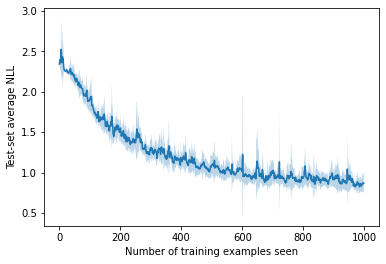

In [51]:
fig, ax = plt.subplots()
ax.plot(fdekf_mean)
ax.fill_between(
    jnp.arange(fdekf_mean.shape[0]),
    fdekf_mean - fdekf_std,
    fdekf_mean + fdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

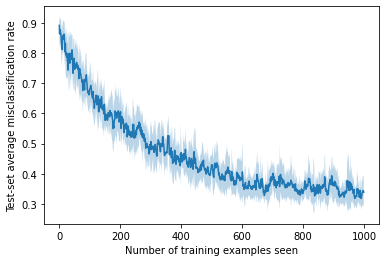

In [52]:
fig, ax = plt.subplots()
ax.plot(fdekf_miscl_mean)
ax.fill_between(
    jnp.arange(fdekf_miscl_mean.shape[0]),
    fdekf_miscl_mean - fdekf_miscl_std,
    fdekf_miscl_mean + fdekf_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 6. VD-EKF

## 6.1 Hyperparam Tuning

In [29]:
vdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='vdekf')
vdekf_optimizer = BayesianOptimization(
    f=vdekf_opt_fn,
    pbounds={
        'log_init_cov': (-7, -0.1),
        'log_dynamics_cov': (-7, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [30]:
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -1.623    | -5.878    | -2.676    | -2.994    |
| 2         | -2.191    | -3.563    | -6.498    | -3.584    |
| 3         | -2.737    | -3.221    | -0.7373   | -6.534    |
| 4         | -27.51    | -2.563    | -1.978    | -4.174    |
| 5         | -2.711    | -4.609    | -0.7727   | -1.145    |
| 6         | -1.224    | -5.122    | -6.225    | -0.3382   |
| 7         | -1e+06    | -0.9052   | -2.958    | -2.792    |
| 8         | -1.45     | -3.196    | -4.041    | -6.437    |
| 9         | -1.771    | -5.573    | -2.49     | -5.814    |
| 10        | -13.68    | -1.909    | -5.925    | -2.807    |
| 11        | -1.564    | -4.864    | -4.643    | -6.873    |
| 12        | -1e+06    | -0.6081   | -6.038    | -1.5      |
| 13        | -1.209    | -6.642    | -3.698    | -0.4555   |
| 14        | -1.597e+2 | -1.286    | -5.622    | -6.917    |
| 15    

In [31]:
# 'log_alpha': -6.642384646194347, 'log_dynamics_cov': -3.698188867067672, 'log_init_cov': -0.45548403950730165
print(vdekf_optimizer.max)

{'target': -1.209222435951233, 'params': {'log_alpha': -6.642384646194347, 'log_dynamics_cov': -3.698188867067672, 'log_init_cov': -0.45548403950730165}}


## 6.2 Test-Set NLL Evaluation

In [53]:
init_cov = jnp.power(10, -0.45548403950730165)
dynamics_cov = jnp.power(10, -3.698188867067672)
alpha = jnp.power(10, -6.642384646194347)
method = 'vdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
vdekf_estimator = RebayesEKF(model_params, method=method)

In [54]:
vdekf_mean, vdekf_std = evaluate_model(vdekf_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
vdekf_miscl_mean, vdekf_miscl_std = evaluate_model(vdekf_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

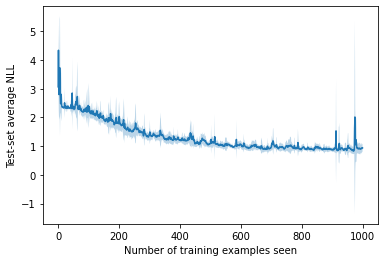

In [56]:
fig, ax = plt.subplots()
ax.plot(vdekf_mean)
ax.fill_between(
    jnp.arange(vdekf_mean.shape[0]),
    vdekf_mean - vdekf_std,
    vdekf_mean + vdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

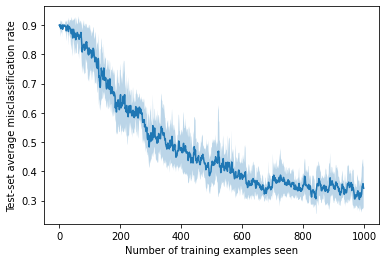

In [57]:
fig, ax = plt.subplots()
ax.plot(vdekf_miscl_mean)
ax.fill_between(
    jnp.arange(vdekf_miscl_mean.shape[0]),
    vdekf_miscl_mean - vdekf_miscl_std,
    vdekf_miscl_mean + vdekf_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 7. Vanilla SGD

## 7.1 Hyperparam Tuning

In [58]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn(params, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [59]:
def train_and_evaluate_model(state, X_train, y_train, evaluate_fn=evaluate_neg_log_likelihood):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    def _step(carry, i):
        state = carry
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
        nll = evaluate_fn(state.params, unflatten_fn, apply_fn, test_ds)
        
        return state, nll
    
    state, nlls = lax.scan(_step, state, jnp.arange(len(X_train)))
    
    return state, nlls

In [60]:
def sgd_opt_fn(log_lr):
    tx = optax.sgd(jnp.power(10, log_lr))
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    _, nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

    result = nlls.mean()
    
    if jnp.isnan(result):
        result = 1e6
    return -result

In [61]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'log_lr': (-7.0, 0.0)}
)

In [62]:
sgd_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -2.488    | -0.08686  |
| 2         | -118.8    | -0.003659 |
| 3         | -2.285    | -4.393    |
| 4         | -2.25     | -3.778    |
| 5         | -1.281    | -1.358    |
| 6         | -2.264    | -3.943    |
| 7         | -1.336    | -1.781    |
| 8         | -2.225    | -3.574    |
| 9         | -2.286    | -4.422    |
| 10        | -1.571    | -0.9419   |
| 11        | -1.286    | -1.506    |
| 12        | -2.386    | -0.4306   |
| 13        | -1.997    | -3.019    |
| 14        | -2.219    | -3.537    |
| 15        | -2.297    | -5.819    |
| 16        | -1.449    | -2.332    |
| 17        | -2.291    | -4.72     |
| 18        | -1.674    | -2.694    |
| 19        | -1.304    | -1.585    |
| 20        | -2.294    | -5.023    |
| 21        | -2.455    | -0.1548   |
| 22        | -2.294    | -5.023    |
| 23        | -1.314    | -1.685    |
| 24        | -2.239    | -3.68     |
| 25        

In [63]:
# 'log_lr': -1.1509916770853854
print(sgd_optimizer.max)

{'target': -1.2712888717651367, 'params': {'log_lr': -1.1509916770853854}}


## 7.2 Test-Set NLL Evaluation

In [64]:
def evaluate_model_sgd(state, X, y, key=0, n_steps=1_000, n_iter=10, evaluate_fn=evaluate_neg_log_likelihood):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = train_and_evaluate_model(state, X_curr, y_curr, evaluate_fn=evaluate_fn)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [65]:
log_lr = -1.1509916770853854

tx = optax.sgd(jnp.power(10, log_lr))
opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
# _, sgd_nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

In [66]:
sgd_mean, sgd_std = evaluate_model_sgd(opt_state, X_train, y_train)

In [67]:
sgd_miscl_mean, sgd_miscl_std = evaluate_model_sgd(opt_state, X_train, y_train, evaluate_fn=evaluate_miscl)

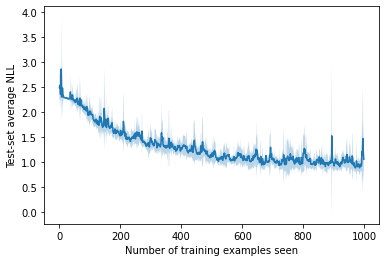

In [68]:
fig, ax = plt.subplots()
ax.plot(sgd_mean)
ax.fill_between(
    jnp.arange(sgd_mean.shape[0]),
    sgd_mean - sgd_std,
    sgd_mean + sgd_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

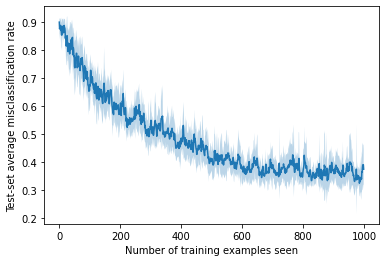

In [69]:
fig, ax = plt.subplots()
ax.plot(sgd_miscl_mean)
ax.fill_between(
    jnp.arange(sgd_miscl_mean.shape[0]),
    sgd_miscl_mean - sgd_miscl_std,
    sgd_miscl_mean + sgd_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 8. Replay-Buffer SGD

## 8.1 Hyperparam Tuning

In [ ]:
@partial(jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    
    nll = -y * jnp.log(probs)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss

In [ ]:
log_lr = 1e-5
tx = optax.sgd(jnp.power(10, log_lr))

rsgd_state = rsgd.FifoTrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=tx,
    buffer_size=20,
    dim_features=28 ** 2,
    dim_output=10,
)

rebayes = rsgd.FSGD(lossfn_fifo, n_inner=2)

In [ ]:
# _, lls = rebayes.scan(X_train[:1000], y_train_ohe[:1000], bel=rsgd_state, callback=ll_callback, **test_kwargs)

## 8.2 Test-Set NLL Evaluation

# 9. Model Comparison

In [70]:
results = {
    'sgd': (sgd_mean, sgd_std),
    'fdekf': (fdekf_mean, fdekf_std),
    'vdekf': (vdekf_mean, vdekf_std),
    'os_lofi': (os_lofi_mean, os_lofi_std),
    'fs_lofi': (fs_lofi_mean, fs_lofi_std),
    'g_lofi': (g_lofi_mean, g_lofi_std),
}

In [71]:
results_miscl = {
    'sgd': (sgd_miscl_mean, sgd_miscl_std),
    'fdekf': (fdekf_miscl_mean, fdekf_miscl_std),
    'vdekf': (vdekf_miscl_mean, vdekf_miscl_std),
    'os_lofi': (os_lofi_miscl_mean, os_lofi_miscl_std),
    'fs_lofi': (fs_lofi_miscl_mean, fs_lofi_miscl_std),
    'g_lofi': (g_lofi_miscl_mean, g_lofi_miscl_std),
}

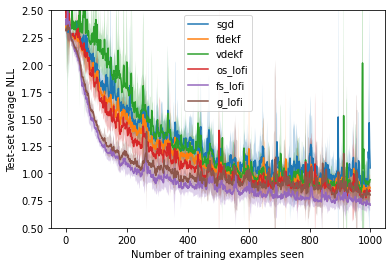

In [73]:
fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.5, 2.5)
ax.legend();

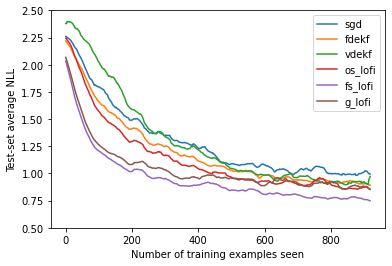

In [75]:
# Smoothed
kernel_size = 40
kernel = jnp.ones((kernel_size,)) / kernel_size

fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(jnp.convolve(mean, kernel, mode='same')[40:-40], label=key)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.5, 2.5)
ax.legend();

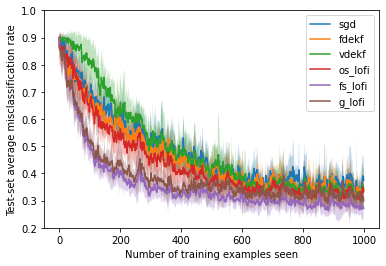

In [77]:
fig, ax = plt.subplots()
for key, val in results_miscl.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate')
ax.set_ylim(0.2, 1.0)
ax.legend();

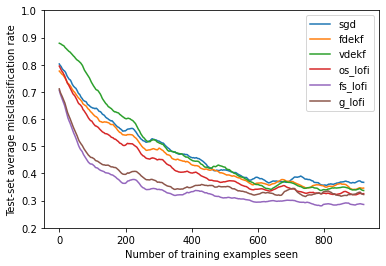

In [78]:
# Smoothed
kernel_size = 40
kernel = jnp.ones((kernel_size,)) / kernel_size

fig, ax = plt.subplots()
for key, val in results_miscl.items():
    mean, std = val
    ax.plot(jnp.convolve(mean, kernel, mode='same')[40:-40], label=key)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate')
ax.set_ylim(0.2, 1.0)
ax.legend();